In [2]:
%pip install neuralforecast

In [4]:
import pandas as pd
import openpyxl
df=pd.read_excel("featured_shihara.xlsx")
nf_df=df.copy()

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from neuralforecast import NeuralForecast
from neuralforecast.models import NBEATSx
from sklearn.metrics import mean_absolute_error, mean_squared_error
import optuna
from optuna.trial import Trial


In [6]:
# Data preparation: Split into train (90%) and test (10%)
train_size = int(len(nf_df) * 0.9)
train_df = nf_df.iloc[:train_size].copy()
test_df = nf_df.iloc[train_size:].copy()

print(f"Training set size: {len(train_df)}")
print(f"Testing set size: {len(test_df)}")

# Handle missing values in both datasets
train_df = train_df.fillna(method='bfill').fillna(method='ffill')
test_df = test_df.fillna(method='bfill').fillna(method='ffill')

# Set up the data in NeuralForecast format
train_data = train_df.copy()
train_data['unique_id'] = 'balance'  # Add required ID column
train_data = train_data.rename(columns={'Date': 'ds', 'Normalized_Balance': 'y'})

test_data = test_df.copy()
test_data['unique_id'] = 'balance'
test_data = test_data.rename(columns={'Date': 'ds', 'Normalized_Balance': 'y'})

# Define forecast horizon
horizon = 30

# Separate features into future and historical
future_features = [
    'dayofweek_sin', 'dayofweek_cos',
    'balance_1d_ago', 'balance_7d_ago', 'balance_30d_ago',
    'rolling_mean_7d', 'rolling_mean_30d',
    'rolling_std_7d', 'rolling_std_30d'
]  # All features we know for tomorrow

historical_features = [
    'balance_changed'  # Only balance_changed is truly historical
]

def create_future_features(df, horizon):
    """Create future features for the forecast period."""
    last_date = df['ds'].max()
    future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=horizon, freq='D')
    
    future_df = pd.DataFrame({'ds': future_dates})
    
    # Calculate day of week features
    future_df['dayofweek_sin'] = np.sin(2 * np.pi * future_df['ds'].dt.dayofweek / 7)
    future_df['dayofweek_cos'] = np.cos(2 * np.pi * future_df['ds'].dt.dayofweek / 7)
    
    # Get the last 30 days of data for reference
    last_30_days = df[df['ds'] >= (last_date - pd.Timedelta(days=30))].copy()
    
    # Initialize all feature columns with the last known values
    for feature in ['balance_1d_ago', 'balance_7d_ago', 'balance_30d_ago',
                   'rolling_mean_7d', 'rolling_mean_30d',
                   'rolling_std_7d', 'rolling_std_30d']:
        future_df[feature] = last_30_days[feature].iloc[-1]
    
    # For each future date, calculate past features
    for i, date in enumerate(future_dates):
        # Calculate how many days we need to look back
        days_from_last = (date - last_date).days
        
        # For balance_1d_ago, use the last known balance for the first day
        if i == 0:
            future_df.loc[i, 'balance_1d_ago'] = last_30_days['y'].iloc[-1]
        else:
            # For subsequent days, use the previous day's prediction
            future_df.loc[i, 'balance_1d_ago'] = future_df.loc[i-1, 'y'] if 'y' in future_df.columns else last_30_days['y'].iloc[-1]
        
        # For balance_7d_ago
        if days_from_last <= 7:
            future_df.loc[i, 'balance_7d_ago'] = last_30_days['y'].iloc[-(7-days_from_last)] if (7-days_from_last) < len(last_30_days) else last_30_days['y'].iloc[-1]
        else:
            future_df.loc[i, 'balance_7d_ago'] = future_df.loc[i-7, 'y'] if 'y' in future_df.columns else last_30_days['y'].iloc[-1]
        
        # For balance_30d_ago
        if days_from_last <= 30:
            future_df.loc[i, 'balance_30d_ago'] = last_30_days['y'].iloc[-(30-days_from_last)] if (30-days_from_last) < len(last_30_days) else last_30_days['y'].iloc[-1]
        else:
            future_df.loc[i, 'balance_30d_ago'] = future_df.loc[i-30, 'y'] if 'y' in future_df.columns else last_30_days['y'].iloc[-1]
        
        # Calculate rolling statistics
        if days_from_last <= 7:
            rolling_data = last_30_days['y'].iloc[-(7-days_from_last):]
            if len(rolling_data) >= 7:
                future_df.loc[i, 'rolling_mean_7d'] = rolling_data.mean()
                future_df.loc[i, 'rolling_std_7d'] = rolling_data.std()
            else:
                # Use the last known rolling statistics
                future_df.loc[i, 'rolling_mean_7d'] = last_30_days['rolling_mean_7d'].iloc[-1]
                future_df.loc[i, 'rolling_std_7d'] = last_30_days['rolling_std_7d'].iloc[-1]
        
        if days_from_last <= 30:
            rolling_data = last_30_days['y'].iloc[-(30-days_from_last):]
            if len(rolling_data) >= 30:
                future_df.loc[i, 'rolling_mean_30d'] = rolling_data.mean()
                future_df.loc[i, 'rolling_std_30d'] = rolling_data.std()
            else:
                # Use the last known rolling statistics
                future_df.loc[i, 'rolling_mean_30d'] = last_30_days['rolling_mean_30d'].iloc[-1]
                future_df.loc[i, 'rolling_std_30d'] = last_30_days['rolling_std_30d'].iloc[-1]
    
    future_df['unique_id'] = 'balance'
    
    # Ensure no null values remain
    for col in future_df.columns:
        if future_df[col].isnull().any():
            # Fill any remaining nulls with the last known value
            future_df[col] = future_df[col].fillna(method='ffill')
            # If still any nulls (at the start), fill with the first non-null value
            future_df[col] = future_df[col].fillna(method='bfill')
    
    return future_df

Training set size: 621
Testing set size: 70


In [8]:
def objective(trial: Trial) -> float:
    """Optuna objective function for hyperparameter optimization."""
    # Define hyperparameter search space optimized for 700 samples
    input_size = trial.suggest_int('input_size', 80, 230)  # 8-25% of data
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    max_steps = trial.suggest_int('max_steps', 800, 2000)
    batch_size = trial.suggest_int('batch_size', 16, 64)
    
    # Create model with trial parameters
    model = NBEATSx(
        h=horizon,
        input_size=input_size,
        futr_exog_list=future_features,
        hist_exog_list=historical_features,
        random_seed=42,
        scaler_type='standard',
        learning_rate=learning_rate,
        max_steps=max_steps,
        batch_size=batch_size
    )
    
    # Create forecaster
    forecaster = NeuralForecast(
        models=[model],
        freq='D'
    )
    
    # Fit model
    forecaster.fit(df=train_data)
    
    # Create future features for prediction
    future_df = create_future_features(train_data, horizon)
    
    # Generate predictions
    forecast_df = forecaster.predict(futr_df=future_df)
    
    # Calculate error metric (using RMSE)
    actual = test_data['y'].iloc[:horizon].values
    forecast = forecast_df.loc[forecast_df['unique_id'] == 'balance', 'NBEATSx'].values
    rmse = np.sqrt(mean_squared_error(actual, forecast))
    
    return rmse


Starting hyperparameter optimization...
Epoch 499: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s, v_num=472, train_loss_step=0.149, train_loss_epoch=0.152]     
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1699: 100%|██████████| 1/1 [00:01<00:00,  0.64it/s, v_num=472, train_loss_step=0.0735, train_loss_epoch=0.0733]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 299: 100%|██████████| 1/1 [00:01<00:00,  0.66it/s, v_num=476, train_loss_step=0.0412, train_loss_epoch=0.0435] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 499: 100%|██████████| 1/1 [00:00<00:00,  1.77it/s, v_num=480, train_loss_step=0.0195, train_loss_epoch=0.0202]2]
Validation: |          | 0/? [00:00<?, ?it/s]
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  7.28it/s]_step=0.0107, train_loss_epoch=0.0107]          

Final Model Performance:
Mean Absolute Error (MAE): 0.1314
Root Mean Squared Error (RMSE): 0.1605
Mean Absolute Percentage Error (MAPE): 37.42%


/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/torch/cuda/__init__.py:789: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/torch/cuda/__init__.py:789: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 4.4 M  | train
-------------------------------------------------------
4.4 M     Trainable params
7.2 K     Non-trainable params
4.4 M     Total params
17.589    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mo

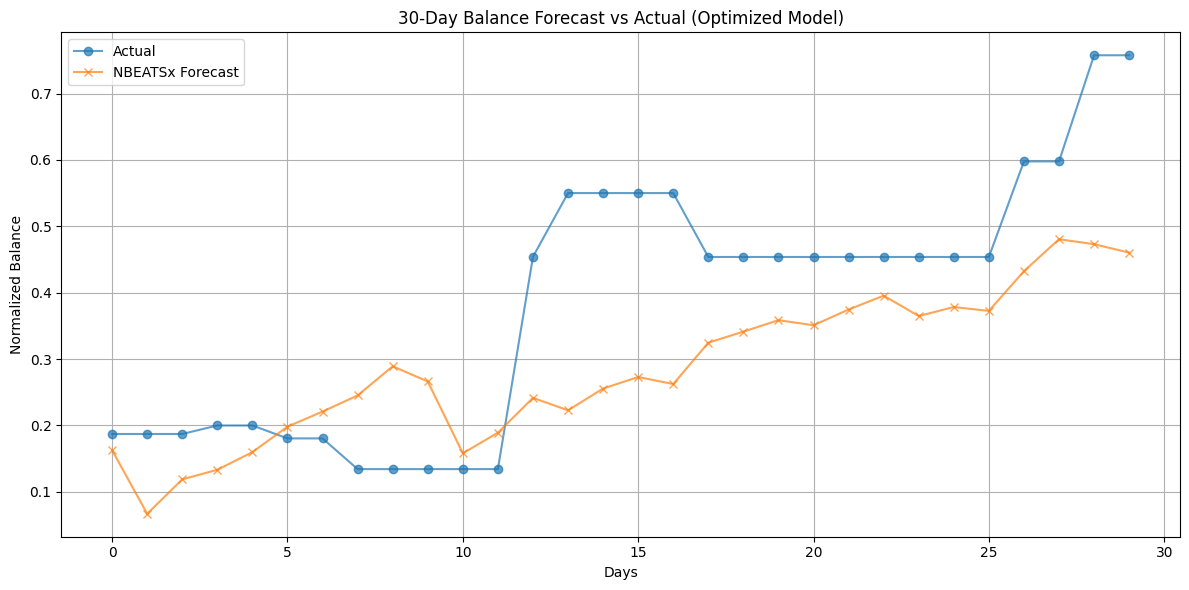

In [10]:
# Run Optuna optimization
print("\nStarting hyperparameter optimization...")
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=5)

# Print best parameters
print("\nBest parameters:")
for key, value in study.best_params.items():
    print(f"{key}: {value}")
print(f"\nBest RMSE: {study.best_value:.4f}")

# Train final model with best parameters
best_model = NBEATSx(
    h=horizon,
    input_size=study.best_params['input_size'],
    futr_exog_list=future_features,
    hist_exog_list=historical_features,
    random_seed=42,
    scaler_type='standard',
    learning_rate=study.best_params['learning_rate'],
    max_steps=study.best_params['max_steps'],
    batch_size=study.best_params['batch_size']
)

# Create final forecaster
final_forecaster = NeuralForecast(
    models=[best_model],
    freq='D'
)

# Fit final model
print("\nTraining final model with best parameters...")
final_forecaster.fit(df=train_data)

# Create future features for final prediction
future_df = create_future_features(train_data, horizon)

# Generate predictions
final_forecast_df = final_forecaster.predict(futr_df=future_df)

# Extract actual values and forecasts
actual = test_data['y'].iloc[:horizon].values
forecast = final_forecast_df.loc[final_forecast_df['unique_id'] == 'balance', 'NBEATSx'].values

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(range(horizon), actual, label='Actual', marker='o', alpha=0.7)
plt.plot(range(horizon), forecast, label='NBEATSx Forecast', marker='x', alpha=0.7)
plt.title('30-Day Balance Forecast vs Actual (Optimized Model)')
plt.xlabel('Days')
plt.ylabel('Normalized Balance')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Calculate final error metrics
mae = mean_absolute_error(actual, forecast)
rmse = np.sqrt(mean_squared_error(actual, forecast))
mape = np.mean(np.abs((actual - forecast) / (actual + 1e-8))) * 100

print("\nFinal Model Performance:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

plt.show() 